<a href="https://colab.research.google.com/github/myredex/wb_fraud_detection/blob/master/wb_hakaton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Wildberries Фрод детекция

## Скачать данные и импортировать библиотеки

In [ ]:
# Импортировать библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import random
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import itertools
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import KBinsDiscretizer, MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.base import BaseEstimator, TransformerMixin


# Установить сид
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# df_train
!gdown 1YHw-ZszkSkLo3UwtPu6fWABJGU6kRJJb

# df_test
!gdown 1YQUMyFUdV-1FQWxpIZ0FugQtQqmgWVi-

Downloading...
From: https://drive.google.com/uc?id=1YHw-ZszkSkLo3UwtPu6fWABJGU6kRJJb
To: /content/df_train.csv
100% 11.7M/11.7M [00:00<00:00, 88.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1YQUMyFUdV-1FQWxpIZ0FugQtQqmgWVi-
To: /content/df_test.csv
100% 1.60M/1.60M [00:00<00:00, 27.2MB/s]


## Функции и классы

In [ ]:
class MultiplyColumns(BaseEstimator, TransformerMixin):
    def __init__(self, pairs):
        """
        Перемножает колонки и создает новые признаки
        pairs: Список кортежей
        Example:
            pairs=[('col1', 'col2', 'sum1'),
                   ('col3', 'col4', 'sum2')]
        """
        self.pairs = pairs

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        for col_1, col_2, new_col_name in self.pairs:
            X[new_col_name] = X[col_1] * X[col_2]
        return X


class DivideColumns(BaseEstimator, TransformerMixin):
    def __init__(self, pairs):
        """
        Разделяет колонки и создает новые признаки
        pairs: Список кортежей
        Example:
            pairs=[('col1', 'col2', 'sum1'),
                   ('col3', 'col4', 'sum2')]
        """
        self.pairs = pairs

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        for col_1, col_2, new_col_name in self.pairs:
            denominator = X[col_2]
            numerator = X[col_1]
            X[new_col_name] = np.where(denominator != 0,
                                    numerator / denominator,
                                    np.nan)
        return X


def get_preds_and_metric(model, X, y):
    # Считает F1 и возвращает предсказания
    y_pred = model.predict(X)
    f1 = f1_score(y, y_pred, average='binary')

    return y_pred, f1


def grid_and_print(pipeline,
                   grid_param,
                   X_train,
                   y_train,
                   X_test=None,
                   y_test=None,
                   n_folds=5,
                   verbose=0):

    # Создаем Грид сеч
    grid_search = GridSearchCV(pipeline,
                               grid_param,
                               cv=n_folds,
                               verbose=verbose,
                               scoring = 'f1',
                               n_jobs=-1)

    # Обучаем Грид сеч
    grid_search.fit(X_train, y_train)

    # Получаем лучшие параметры
    best_params = grid_search.best_params_
    print(f"Лучшие параметры: {best_params}")

    # Получаем лучшую модель
    best_model = grid_search.best_estimator_

    # Получаем предсказания на Трэйн
    y_pred_train, f1_train = get_preds_and_metric(model=best_model,
                                                    X=X_train,
                                                    y=y_train)

    # Если есть тестовые\валидационные данные
    if X_test is not None and y_test is not None:
        # Получаем предсказания на Тест
        y_pred_test, f1_test = get_preds_and_metric(model=best_model,
                                                    X=X_test,
                                                    y=y_test)

        # Считаю дстанцию между трейн и валидацией
        distance = ((f1_train - f1_test) / f1_test) * 100

        print(f"F1_train: {f1_train:.4f}. F1_test: {f1_test:.4f}.  Distance: {distance:.2f}%")

        # Строим конфьюжн матрицу
        make_confusion_matrix(y_true=y_test,
                        y_pred=y_pred_test)

    else:
        print(f"F1_train: {f1_train:.4f}.")

    return best_model


def get_pipeline_results(pipeline,
                         X_train,
                         y_train,
                         X_test,
                         y_test,
                         estimator_params=None):

    if estimator_params:
        pipeline.set_params(**estimator_params)

    # Обучаем Пайплайн сеч
    pipeline.fit(X_train,
                 y_train)

    # Получаем предсказания на Трэйн
    y_pred_train, f1_train = get_preds_and_metric(model=pipeline,
                                                    X=X_train,
                                                    y=y_train)

    # Получаем предсказания на Тест
    y_pred_test, f1_test = get_preds_and_metric(model=pipeline,
                                                X=X_test,
                                                y=y_test)

    distance = ((f1_train - f1_test) / f1_test) * 100

    print(f"F1_train: {f1_train:.4f}. F1_test: {f1_test:.4f}. Distance: {distance:.2f}%")

    make_confusion_matrix(y_true=y_test,
                          y_pred=y_pred_test)

    return pipeline


def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).

  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

## Краткий EDA

## Создать датафреймы

In [ ]:
# Загружаем датафреймы
df_train = pd.read_csv("df_train.csv")
df_test = pd.read_csv("df_test.csv")

len(df_train), len(df_test), df_train.columns, df_train.dtypes

(Index(['user_id', 'nm_id', 'CreatedDate', 'service', 'total_ordered',
        'PaymentType', 'IsPaid', 'count_items', 'unique_items',
        'avg_unique_purchase', 'is_courier', 'NmAge', 'Distance',
        'DaysAfterRegistration', 'number_of_orders', 'number_of_ordered_items',
        'mean_number_of_ordered_items', 'min_number_of_ordered_items',
        'max_number_of_ordered_items', 'mean_percent_of_ordered_items',
        'target'],
       dtype='object'),
 user_id                            int64
 nm_id                              int64
 CreatedDate                       object
 service                           object
 total_ordered                      int64
 PaymentType                       object
 IsPaid                              bool
 count_items                        int64
 unique_items                       int64
 avg_unique_purchase              float64
 is_courier                         int64
 NmAge                              int64
 Distance                    

Проверим балланс целевого класса.

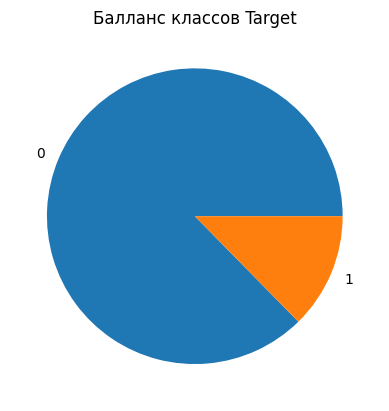

target
0    92211
1    13354
Name: count, dtype: int64


In [ ]:
plt.pie(df_train.target.value_counts(),
        labels=df_train.target.value_counts().index)
plt.title('Балланс классов Target')

plt.show()
print(df_train.target.value_counts())

Датасет представлен в табличном формате и содержит следующие колонки:

* **user_id** - идентификатор пользователя
created_date - дата создания записи
* **nm_id** - идентификатор товара
* **total_ordered** - общее количество заказанных товаров
* **payment_type** - тип оплаты
* **is_paid** - флаг оплаты (булево значение)
* **count_items** - количество товаров за последнее время
* **unique_items** - количество уникальных товаров за последнее время
* **avg_unique_purchase** - среднее количество уникальных покупок за последнее время
* **is_courier** - флаг доставки курьером
* **nm_age** - возраст товара
* **Distance** - расстояние
* **days_after_registration** - дни после регистрации
* **number_of_orders** - количество заказов
* **number_of_ordered_items** - количество заказанных товаров
* **mean_number_of_ordered_items** - среднее количество заказанных товаров
* **min_number_of_ordered_items** - минимальное количество заказанных товаров
* **max_number_of_ordered_items** - максимальное количество заказанных товаров
* **mean_percent_of_ordered_items** - средний процент заказанных товаров
* **target** - целевая переменная (0 - не требуется блокировка, 1 - требуется блокировка)
* **service** - тип региона

Датасет имеет сильный дисбаланс классов в соотношении 1:10 (класс 1 встречается значительно реже).


Оценим корреляцию признаков.

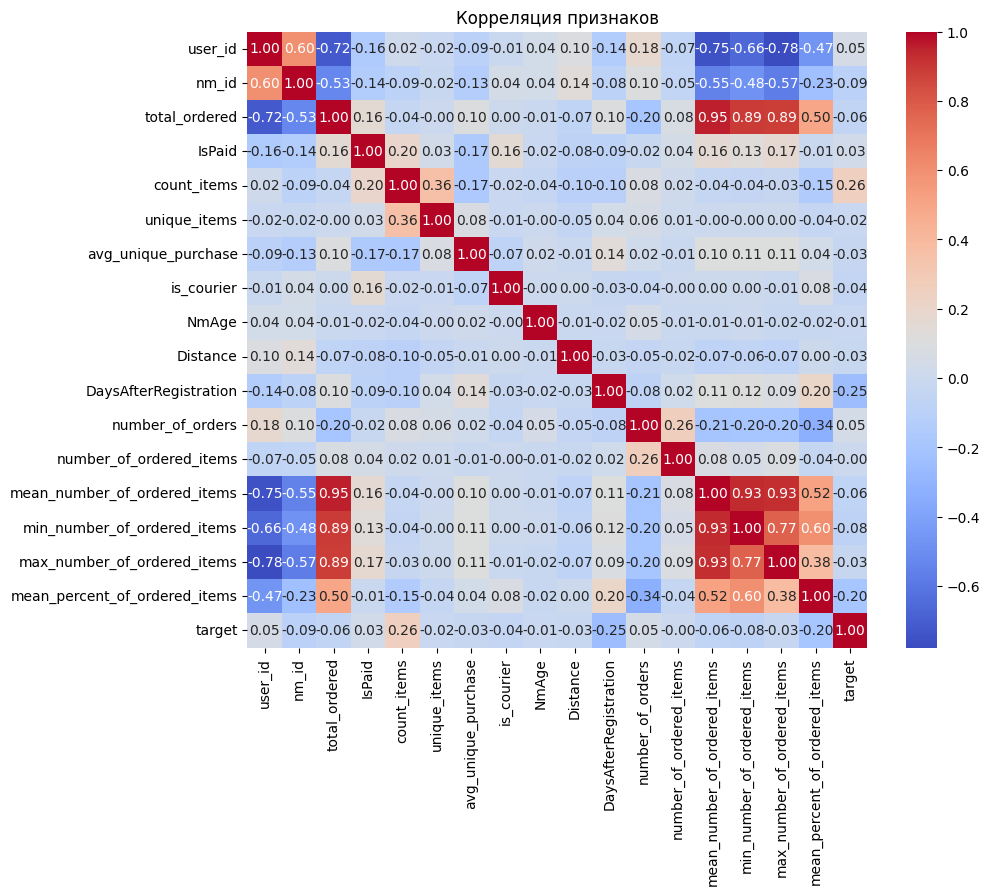

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(df_train.corr(numeric_only=True), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Корреляция признаков")
plt.show()

## Строим Пайплайн

In [ ]:
# Создать датафрейм для обучения
X = df_train.drop('target', axis=1)
y = df_train['target']

# Создать полные Тестовые данные (для главной метрики)
X_test_full = df_test.drop('target', axis=1)
y_test_full = df_test['target']

# Разделяю данные на Трейн и Тест(валидация)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=SEED)

# Проверить размеры датафреймов
X_train.shape, X_val.shape, y_train.shape, y_val.shape, X_test_full.shape, y_test_full.shape

((84452, 20), (21113, 20), (84452,), (21113,), (14261, 20), (14261,))

In [ ]:
# Разделяем признаки на типы
numerical_features = ['total_ordered', # важный
                      'count_items', # важный
                      'uni_div_days',
                      'days_div_orders',

                      'DaysAfterRegistration',
                      'unique_items', # важный
                      'avg_unique_purchase',  # важный
                      'is_courier', # вопрос
                      'NmAge',  # важный
                      'Distance', # норм
                      'DaysAfterRegistration', # Оч важн
                      'number_of_orders', # вопрос
                      'number_of_ordered_items', # вопрос
                      'mean_number_of_ordered_items', # вопрос
                      # 'min_number_of_ordered_items', # корр с mean_number_of_ordered_items
                      # 'max_number_of_ordered_items', # корр с mean_number_of_ordered_items
                      'mean_percent_of_ordered_items'# вопрос
                      ]

binning_features = [
                    ]

categorical_features = ['PaymentType',
                        'IsPaid',
                        'service'
                        ]

# Добавляю новые фичи
# Перемножить колонки
multiply_columns = MultiplyColumns(
    pairs=[
        ('count_items', 'unique_items', 'count_to_unique')
    ]
)

# Разделить колонки
divide_columns = DivideColumns(
    pairs=[
        ('unique_items', 'DaysAfterRegistration', 'uni_div_days'),
        ( 'DaysAfterRegistration', 'number_of_orders', 'days_div_orders')
    ]
)

# Создаем трансформеры
num_transformer =  Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
])

cat_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

bin_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('encoder', KBinsDiscretizer(n_bins=5,
                                 encode='ordinal',
                                 strategy='uniform'))
])

# Трансформируем столбцы
column_transformer = ColumnTransformer([
    ('num', num_transformer, numerical_features),
    ('cat', cat_transformer, categorical_features),
 ('bin', bin_transformer, binning_features)
])

# Уравновесим классы
smote = SMOTE(random_state=SEED)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Лучшие параметры: {'estimator__class_weight': 'balanced', 'estimator__max_depth': 7, 'estimator__min_samples_leaf': 3, 'estimator__n_estimators': 100}
F1_train: 0.6741. F1_test: 0.6782.  Distance: -0.61%


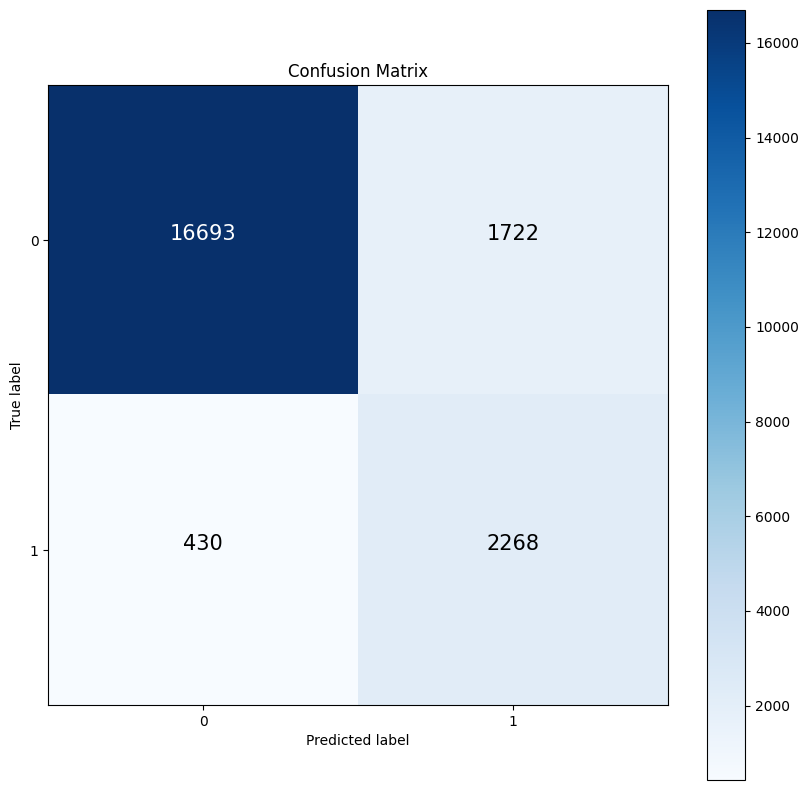

In [ ]:
# Финальный пайплайн
pipe_1 = Pipeline([
                ('muliply_columns', multiply_columns),
                ('divide_columns', divide_columns),
                ('preprocessing', column_transformer),
                ('smote', smote),
                ('estimator', RandomForestClassifier(random_state=SEED))
                ])

rf_params = {
#  'estimator__bootstrap': True,
#  'estimator__ccp_alpha': 0.0,
'estimator__class_weight': 'balanced',
#  'estimator__criterion': 'gini',
'estimator__max_depth': 7,
# 'estimator__max_features': 'sqrt',
#  'estimator__max_leaf_nodes': None,
#  'estimator__max_samples': None,
#  'estimator__min_impurity_decrease': 0.0,
'estimator__min_samples_leaf': 3,
#  'estimator__min_samples_split': 2,
#  'estimator__min_weight_fraction_leaf': 0.0,
#  'estimator__monotonic_cst': None,
'estimator__n_estimators': 100,
#  'estimator__n_jobs': None,
#  'estimator__oob_score': False,
#  'estimator__random_state': None,
#  'estimator__verbose': 0,
#  'estimator__warm_start': False
}

rf_params_grid = {
'estimator__class_weight': ['balanced'],
'estimator__max_depth': [7],
'estimator__min_samples_leaf': [3],
'estimator__n_estimators': [100],
}

# pipe = get_pipeline_results(pipeline=pipe_1,
            #                 estimator_params=rf_params,
            #                 X_train=X_train,
            #                 y_train=y_train,
            #                 X_test=X_test,
            #                 y_test=y_test)

# Обучаю модель на трейне и проверка на валидационных данных
pipe_1_model = grid_and_print(pipeline=pipe_1,
                                grid_param=rf_params_grid,
                                X_train=X_train,
                                y_train=y_train,
                                X_test=X_val,
                                y_test=y_val,
                                verbose=2)

In [ ]:
# Обучаю модель на полных данных датасета ТРЕЙН
pipe_1_model_final = grid_and_print(pipeline=pipe_1,
                grid_param=rf_params_grid,
                X_train=X,
                y_train=y,
                verbose=2)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Лучшие параметры: {'estimator__class_weight': 'balanced', 'estimator__max_depth': 7, 'estimator__min_samples_leaf': 3, 'estimator__n_estimators': 100}
F1_train: 0.6641.


## Предсказания на Тестовых данных

In [ ]:
# Предсказания на тестовых данных
y_pred_test_full, f1_test_full = get_preds_and_metric(model=pipe_1_model_final,
                                                    X=X_test_full,
                                                    y=y_test_full)

print(f"F1 test full: {f1_test_full:.4f}")

F1 test full: 0.3319


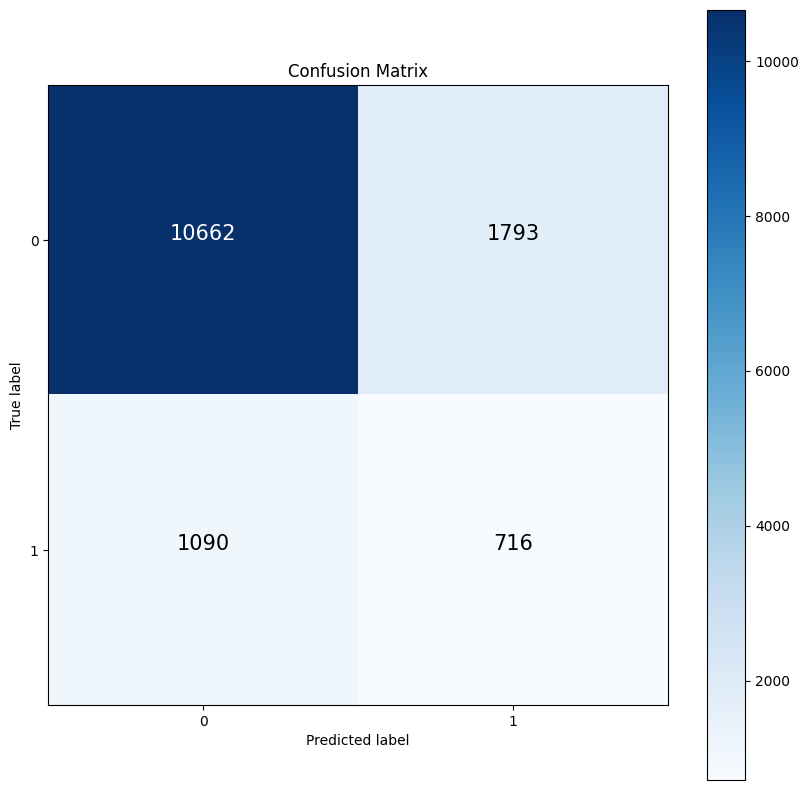

In [ ]:
# Строим конфьюжн матрицу для полного Тестового датафрейма
make_confusion_matrix(y_true=y_test_full,
                        y_pred=y_pred_test_full)

### Финальный результат F1 на тестовых данных: 0.3319

## Сохраняю модель

In [ ]:
# Сохраняем модель
joblib.dump(pipe_1_model_final, 'pipe_1_model_final.joblib')

['pipe_1_model_final.joblib']